<a href="https://colab.research.google.com/github/mr-alamdari/Single-Object-Segmentation-Pytorch/blob/main/Single_Object_Segmentation_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import scipy
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries
import torch
import torchsummary

#1.Data

###The Dataset is From Automated measurement of fetal head circumference competition on the Grand Challenge website

####The dataset contains the two-dimensional (2D) ultrasound images of the standard plane [Source](https://zenodo.org/record/1322001#.XcX1jk9KhhE)

In [ ]:
!wget https://zenodo.org/record/1322001/files/training_set.zip
!wget https://zenodo.org/record/1322001/files/test_set.zip

--2022-03-31 06:35:58--  https://zenodo.org/record/1322001/files/training_set.zip
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 132986834 (127M) [application/octet-stream]
Saving to: ‘training_set.zip’

training_set.zip    100%[===================>] 126.83M  6.73MB/s    in 32s     

2022-03-31 06:36:32 (3.95 MB/s) - ‘training_set.zip’ saved [132986834/132986834]

--2022-03-31 06:36:32--  https://zenodo.org/record/1322001/files/test_set.zip
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 43751086 (42M) [application/octet-stream]
Saving to: ‘test_set.zip’

test_set.zip        100%[===================>]  41.72M  4.08MB/s    in 67s     

2022-03-31 06:37:41 (636 KB/s) - ‘test_set.zip’ saved [43751086/43751086]



In [ ]:
!unzip training_set.zip
!unzip test_set.zip

Archive:  training_set.zip
   creating: training_set/
 extracting: training_set/100_2HC.png  
  inflating: training_set/100_2HC_Annotation.png  
 extracting: training_set/101_HC.png  
  inflating: training_set/101_HC_Annotation.png  
 extracting: training_set/102_2HC.png  
  inflating: training_set/102_2HC_Annotation.png  
 extracting: training_set/103_HC.png  
  inflating: training_set/103_HC_Annotation.png  
 extracting: training_set/104_HC.png  
  inflating: training_set/104_HC_Annotation.png  
 extracting: training_set/105_HC.png  
  inflating: training_set/105_HC_Annotation.png  
 extracting: training_set/106_HC.png  
  inflating: training_set/106_HC_Annotation.png  
 extracting: training_set/107_HC.png  
  inflating: training_set/107_HC_Annotation.png  
 extracting: training_set/108_2HC.png  
  inflating: training_set/108_2HC_Annotation.png  
 extracting: training_set/109_HC.png  
  inflating: training_set/109_HC_Annotation.png  
 extracting: training_set/10_2HC.png  
  inflating

In [ ]:
os.mkdir('/content/data')
os.replace('/content/training_set', '/content/data/training_set')
os.replace('/content/test_set', '/content/data/test_set')
os.remove('/content/training_set.zip')
os.remove('/content/test_set.zip')

In [ ]:
path2train = '/content/data/training_set'
path2test = '/content/data/test_set'

imgs_list, annts_list = list(), list()
for path in os.listdir(path2train):
  if 'Annotation' in path:
    annts_list.append(path)
  else:
    imgs_list.append(path)

In [ ]:
len(annts_list), len(imgs_list)

(999, 1000)

In [ ]:
def show_img_mask(img, mask):
    img_mask = mark_boundaries(np.array(img),
                               np.array(mask),
                              outline_color=(0, 1, 0),
                               color=(0, 1, 0))
    plt.imshow(img_mask)

In [ ]:
def show_img(n):
  for im in np.random.choice(imgs_list, n):
    path2img = f'{path2train}/{im}'
    path2ann = path2img.replace('.png', '_Annotation.png')
    img = Image.open(path2img)
    annt_edges = Image.open(path2ann)
    mask = scipy.ndimage.binary_fill_holes(annt_edges)

    plt.figure(figsize=(20, 100))
    plt.subplot(1, n, 1)
    plt.imshow(img, cmap='gray')
    
    plt.subplot(1, n, 2)
    plt.imshow(mask, cmap='gray')

    plt.subplot(1, n, 3)
    show_img_mask(img, mask)

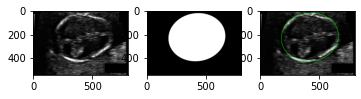

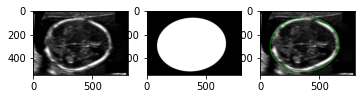

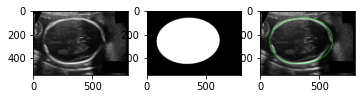

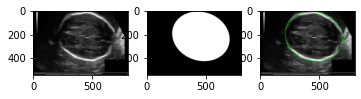

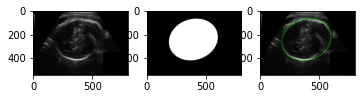

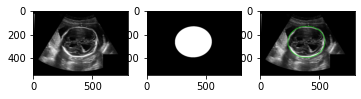

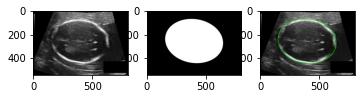

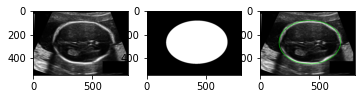

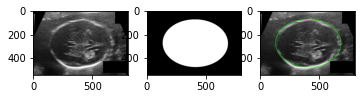

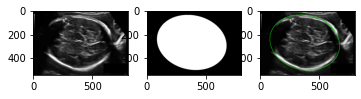

In [ ]:
show_img(10)

##Data Augmentation

####I will use the albumentations package to augment the data for segmentation tasks:
#####!pip install imgaug
#####!pip install albumentations

In [ ]:
# !pip install imgaug
# !pip install albumentations

In [ ]:
from albumentations import HorizontalFlip, VerticalFlip, Compose, Resize

h, w = 128, 192
transform_train = Compose([Resize(h, w),
                           HorizontalFlip(p=0.5),
                           VerticalFlip(p=0.5)])

transform_val = Resize(h, w)

In [ ]:
class Fetal_Dataset(torch.utils.data.Dataset):

  def __init__(self, path2data, transform=None):

    imgs_list, annts_list = list(), list()
    for path in os.listdir(path2data):
      if 'Annotation' in path:
        annts_list.append(path)
      else:
        imgs_list.append(path)
   
    self.path2imgs = [os.path.join(path2data, p) for pi in imgs_list]
    self.path2annts = [os.path.join(path2data, p) for pa in annts_list]
    self.transform = transform
  
  def __len__(self):
    return len(self.path2imgs)
  
  def __getitem__(self, idx):
    path2img = self.path2imgs[idx]
    image = Image.open(path2img)   

    path2annt = self.path2annts[idx]
    annt_edges = Image.open(path2annt)
    mask = scipy.ndimage.binary_fill_holes(annt_edges)
    mask = mask.astype('uint8')
    if self.transform:
      augmented_img = self.transform(image=image, mask=mask)
      image = augmented_img['image']
      mask = augmented_img['mask']

    image = torchvision.transforms.functional.to_tensor(image)
    mask = 255 * torchvision.transforms.functional.to_tensor(mask)
    return image, mask

SyntaxError: ignored

In [ ]:
fetal_ds1 = Fetal_Dataset(path2train, transform=transform_train)
fetal_ds2 = Fetal_Dataset(path2train, transform=transform_val)

In [ ]:
show_img_mask(fetal_ds1[23])

In [ ]:
from sklrean import model_selection
sss = model_selection.SuffleSplit(n_splits=1, test_size=0.2, random_state=32)
indices = range(len(fetal_ds1))

In [ ]:
for train_index, val_index in sss.split(indecs):
  print(len(train_index), len(val_index))

In [ ]:
train_ds = torch.utils.data.Subset(fetal_ds1, train_index)
test_ds = torch.utils.data.Subset(detal_ds2, val_index)

In [ ]:
train_dl = torch.utils.data.DataLoader(train_ds,
                                       batch_size=8,
                                       shuffle=True)
test_dl = torch.utils.data.DataLoader(test_dl,
                                      batch_size=16,
                                      shuffle=False)